In [1]:
import MyLibrary.phantom as ph
import MyLibrary.RayTransform as RT

import numpy as np
import matplotlib.pyplot as plt

# Computerized Tomography

Computerized tomography (CT) became one of the most popular and standard imaging techniques for medical and industrial applications. Its principle  lies on the property of propagation of X-rays, discovered by Wilhelm Röntgen in 1895 at the university of Würzburg, and was developed by Godfrey Hounsfield who won the Nobel Price in 1979 with Allan M. Cormack who studied the inverse problem associated to the so-called Radon transform.


A photon beam, represented by its intensity $I$, flying in a closed domain $\Omega$ with energy $E$ and direction $\vartheta$ satisfies the \textbf{stationary transport equation}
$$
\vartheta \cdot \nabla_\mathbf{x} I(\mathbf{x},\vartheta) + a_E(\mathbf{x}) I(\mathbf{x},\vartheta) = 0, \qquad \mathbf{x} \in \Omega
$$
with $a_E(\mathbf{x})$ called the lineic attenuation coefficient at energy $E$. This coefficient depends on the type of material and represents the \textit{resistance} of the atomic structure to the propagation of the photons. Consider two points S (source) and D (detector) with respective position $s$ and $d$ and note $s-d = r\vartheta$. Solving this ordinary differential equation between S and D leads to the so-called \textbf{Beer-Lambert law} which describes the attenuation of the photon beam between S and D
$$
I(\mathbf{s}+r\vartheta,\vartheta)= I(\mathbf{s},\vartheta) \exp\left(-\int_{0}^{r} a_E\left(\mathbf{s}+ t \vartheta \right) \mathrm{d}t\right).
$$
\vspace{1em}
This relation implies that knowing the intensity at S and measuring the intensity at D gives an information about the integral of the attenuation coefficient under the form 
$$
\ln \frac{I(\mathbf{s},\vartheta)}{I(\mathbf{s}+r\vartheta,\vartheta)} = \int_{0}^{r} a_E\left(\mathbf{s}+ t \vartheta \right) \mathrm{d}t.
$$
Assuming that the object is compactly supported into $\Omega$ and neglecting the attenuation of the air around the object, one gets 
$$
\ln \frac{I(\mathbf{s},\vartheta)}{I(\mathbf{s}+r\vartheta,\vartheta)} = \int_{\mathbb{R}} a_E\left(\mathbf{s}+ t \vartheta \right) \mathrm{d}t
$$
which is simply the integral of the attenuation coefficient along the straight line passing through $s$ with direction $\vartheta$. In two dimensions, this coincides with the X-ray transform or after a suited change of variable with the well-known Radon transform.


## Parallel Geometry

### Radon transform (1917)

Let $f\in S(\Omega)$, $\Omega \subset \mathbb{R}^2$. Then, the Radon transform maps $f$ into its line integrals
$$
\mathcal{R} f(p,\theta) := \int_{\mathbf{x}^\top \theta = p} f(\mathbf{x}) d\mathbf{x} = \int_{\Omega} \delta(\mathbf{x}^\top \theta - p) f(\mathbf{x}) d\mathbf{x} = \int_\mathbb{R} f(p\theta + t\theta^\perp)dt, \quad (p,\theta) \in \mathbb{R} \times S^1.
$$
Here $p=\mathbf{x}^\top \theta$ stands for the normal form of the straight line with normal vector $\theta = (\cos\varphi,\sin\varphi)^\top$, $\varphi \in [0,2\pi]$ and distance to the origin $p$. The straight line denoted by $L(p,\theta)$ is defined by
$$
L(p,\theta) := \lbrace \mathbf{x} \in \mathbb{R}^2 \ : \ p = \mathbf{x}^\top \theta = x \cos \varphi + y \sin \varphi  \rbrace.
$$
In the 2D case, $\theta^\perp = \vartheta = (\mathbf{d}-\mathbf{s})/\Vert \mathbf{d}-\mathbf{s}\Vert$.

<img src="./Images/CTscan_parallel.png" alt="" width="400" height="400"/>


### Discretization


Both lines and the sinogram are discretized by two vectors $(p_k)_k$ and $(\varphi_l)_l$. For instance,  $(p_k)_k \in [-P,P]^\kappa \subset \mathbb{R}^{\kappa}$, $P>0$, and $(\varphi_l)_l = (0,\ldots,\pi(\lambda-1)/\lambda)~\in~\mathbb{R}^\lambda$. In the code below, this corresponds to 
* <code>p = -N/2 + N*np.arange(0,1,1/Ndetector)</code> 
* <code>phi = np.arange(0,Nrota)*np.pi/(Nrota-1)</code>

In [2]:
#Parameters of the CT-scan
modality = 'parallel'
N        = 121
Nrota    = N
Ndetector= 2*N+1
dp       = N/Ndetector 
center   = [int((N+1)/2),int((N+1)/2)]#[N/2,N/2]
p        = dp * np.arange(-int(Ndetector/2),int(Ndetector/2)) 
phi      = np.arange(0,Nrota)*np.pi/(Nrota-1) 
parameters = (p,phi,N,center)

In order to discretize, we first develop $f$ in a given basis $(b_i)_i$ so that
$$
f(x,y) = \sum_{i=1}^{n} f_i \: b_i(x,y) \ .
$$
The most common choice for $(b_i)_{i=1,\ldots,n}$ is the pixel basis with $n$ the total number of pixels. 

The Shepp-Logan phantom is considered below.

In [3]:
#The toy image to project and then reconstruct
f0    = ph.phantom(N)

<!--
It can be necessary to consider the sinogram as a vector. In this case, we simply assign $(p_k,\varphi_l)_{k,l} \in \mathbb{R}^\kappa \times \mathbb{R}^\lambda$ into $(p_{k(j)})_j,(\varphi_{l(j)})_j \in \mathbb{R}^m$ with $m := \kappa \times \lambda$. The index $j$ here characterizes a straight line $L_j := \lbrace p_{k(j)} \theta_{l(j)} + t\theta_{l(j)}^\perp \ | \ t\in \mathbb{R} \rbrace$. 
-->
The Radon transform defined above can be considered as the following system of linear equations from a discrete point of view:
$$
\mathbf{g} = \mathbf{R} \mathbf{f}, \qquad \mathbf{g} = (g_1,\ldots,g_m)^\top \in \mathbb{R}^m, \ \mathbf{f}=(f_1,\ldots,f_n)^\top \in \mathbb{R}^n, \ \ \mathbf{R}=(r_{ji})_{ji} \in \mathbb{R}^{m\times n}, \ m := \kappa \times \lambda.
$$
Here $\mathbf{g}$ and $\mathbf{f}$ denote flattened versions of the corresponding sinogram $g$ and image $f$.  

$\mathbf{R}$ is usually called <i>projection matrix</i>. Depending on the choice of interpolation and/or physical representation, $\mathbf{R}$ can have different definitions. The class <code>RayTransform</code> can compute $\mathbf{R}$ with the method <code>computeProjectionMatrix()</code> following two options:
* <code> method = length </code> (default): delivers entries $(r_{ji})_{ji}$ of $\mathbf{R}$ as the length of the intersection between the $j$-th straight line by $L_j$ and the $i$-th pixel $P_i$ centered at $(x_i,y_i)$.
* <code> method = gaussian </code>: delivers entries $(r_{ji})_{ji}$ of $\mathbf{R}$ computed analytically when the basis $(b_i)_i$ corresponds to Gaussian functions centered at $(x_i,y_i)$.

The matrix $\mathbf{R}$ has two possible types:
* <code>datatype = matrix</code> (default): standard numpy.ndarray,
* <code>datatype = sparse</code>: sparse "matrix" with type <code>dict</code> which reduces substantially the size of $\mathbf{R}$ but increases also the computation time of the reconstruction techniques.

Once the projection matrix is computed, one can compute the data $g$ from $\mathbf{g} = \mathbf{Rf}$ with the method
<code>getdata()</code>. Alternatively, it is possible to compute the data in parallel geometry from the line integrals directly without using the projection matrix via the method <code>RadonTransform()</code>.


In [4]:
#Computation of the projection matrix and data
Xpara = RT.RayTransform(parameters,modality=modality)
Xpara.computeProjectionMatrix(method='pixel')
g     = Xpara.getData(f0) 
gRT   = Xpara.RadonTransform(f0)

Projection Matrix: [##########]100%  Time elapsed: 6.7 seconds
Line integrals: [##########]100%  Time elapsed: 13.5 seconds


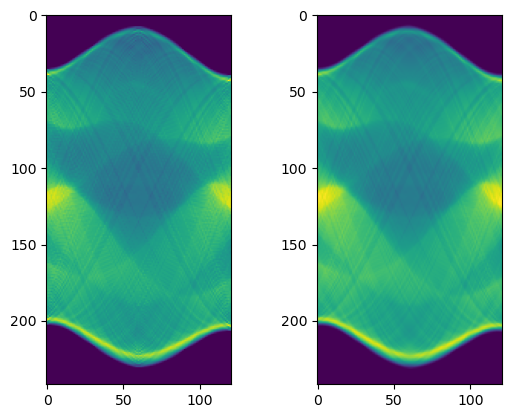

In [5]:
#Visualisation of the data
fig, (ax1, ax2) = plt.subplots(1, 2, num=3)
ax1.imshow(g)
ax2.imshow(gRT)
plt.show()


### The inverse Radon transform

Let $g = \mathcal{R} f$ with $f \in S(\Omega)$, $\Omega \subset \R^2$, then
$$
f(x) = \frac{1}{4\pi} \mathcal{R}^\star \mathcal{I}^{-1} g(x).
$$
with $\mathcal{I}^{-1}$ the Riesz potential defined as 
$$
\mathcal{F}(\mathcal{I}^{-1} u) (\nu) = |\nu| \mathcal{F}(u)(\nu).
$$
The inversion formula reads 
$$
f = \frac{1}{4\pi} \mathcal{R}^\star \mathcal{F}^{-1}(|\nu| \cdot \hat{g}).
$$ 
The ill-posedness of the inverse problem $g = \mathcal{R} f$ is revealed by the growth of $|\nu|$ for high-frequencies. To regularize, one needs to apodize the frequencies with a smooth filter $\sigma_\gamma$ which leads to the well-known filtered backprojection (FBP)
$$
f_\gamma = \frac{1}{4\pi} \mathcal{R}^\star \mathcal{F}^{-1}(\sigma_\gamma(\nu)|\nu| \cdot \hat{g}).
$$ 
The resulting $f_\gamma$ can be obtained by the class method <code>FBP()</code>.

### The Approximate Inverse

In order to regularize the inverse problem $g = \mathcal{R} f$, the Approximate Inverse proposes to smooth the solution space, i.e.
$$
f^\gamma(\mathbf{x})=\langle f,e^\gamma_\mathbf{x}\rangle
$$
with a prescribed mollifier $e^\gamma_\mathbf{x}$ by solving the auxiliary problem 
$$
\mathcal{R}^* \psi^\gamma_\mathbf{x} = e^\gamma_\mathbf{x}.
$$
Then the reconstruction is obtained by
$$
f^\gamma(\mathbf{x})=\langle f,e^\gamma_\mathbf{x}\rangle = \langle f,\mathcal{R}^*\psi^\gamma_\mathbf{x}\rangle = \langle \mathcal{R}f,\psi^\gamma\rangle = \langle g,\psi^\gamma_\mathbf{x}\rangle
$$
and more specifically for the Radon transform by
$$
f^\gamma (\mathbf{x})  =\int_{S^1} \int_{-1}^1 g(p,\theta)\, \Psi^\gamma(p-\mathbf{x}^T\theta,\theta)\,\mathrm{d}p\,\mathrm{d}\theta
$$
where  $\psi^\gamma_\mathbf{x}=\Psi^\gamma(p-\mathbf{x}^T\theta,\theta)$.

#### How to compute $\Psi^\gamma$?
With the inversion formula of $\mathcal{R}$, it holds
$$
\mathcal{R}^* \Psi^\gamma = \frac{1}{2}(2\pi)^{1-n} \mathcal{R}^* \mathcal{I}^{1-n}\mathcal{R} E^\gamma\quad 
\Rightarrow \quad \Psi^\gamma = \frac{1}{2}(2\pi)^{1-n}\mathcal{I}^{1-n}\mathcal{R} E^\gamma
$$
where $e^\gamma_\mathbf{x} = E_\gamma(\mathbf{y}-\mathbf{x})$. For given mollifier such as the Gaussian function then the reconstruction kernel $\psi^\gamma_\mathbf{x}$ is analytically known. This is implemented in the class method <code>ApproximateInverseRT</code>.

In [20]:
#Reconstructions using FBP and Approximate Inverse
fFBP_II = Xpara.FBP(gRT,filtertype='ram-lak')
fFBP_MI = Xpara.FBP(g,filtertype='hann')
fFBP_IM = Xpara.FBP(gRT,method='matrix',filtertype='shepp-logan')
fFBP_MM = Xpara.FBP(g,method='matrix',filtertype='cosine')
fAI_II  = Xpara.ApproximateInverseRT(gRT,gamma=dp/np.sqrt(2))#dp/1.2)
fAI_MI  = Xpara.ApproximateInverseRT(g,gamma=dp/np.sqrt(2))#dp/1.2)

FBP: [##########]100%  Time elapsed: 0.1 seconds
FBP: [##########]100%  Time elapsed: 0.1 seconds
ApproxInverse: [##########]100%  Time elapsed: 13.1 seconds
ApproxInverse: [##########]100%  Time elapsed: 25.0 seconds


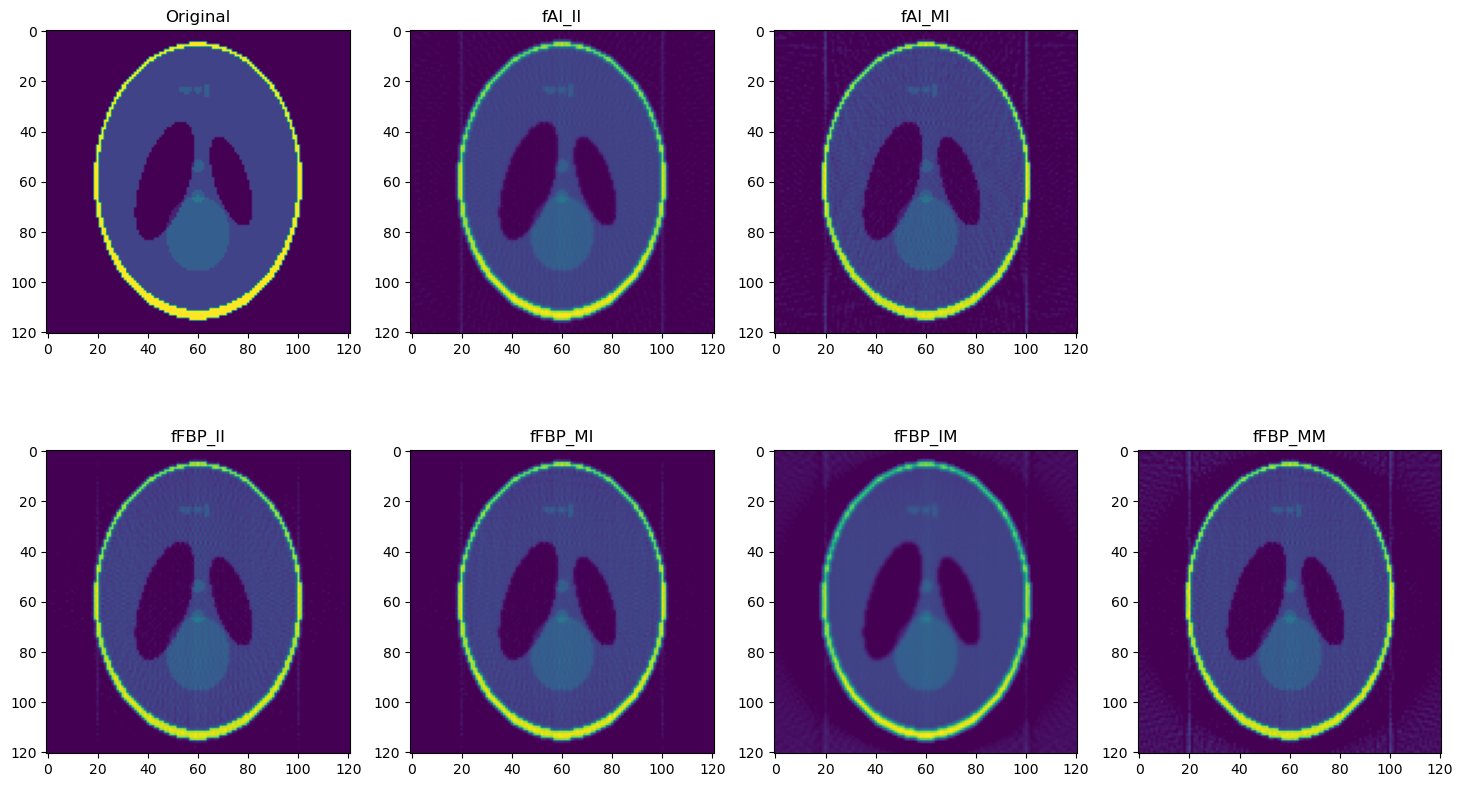

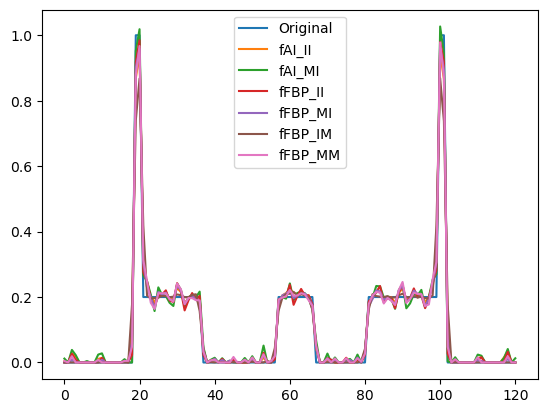

In [21]:
#Visualisation of the reconstructions
fig, axs = plt.subplots(2,4, num=4)
fig.set_size_inches(18,10)
axs[0,0].imshow(f0)
axs[0,0].set_title('Original')
axs[0,1].imshow(fAI_II)
axs[0,1].set_title('fAI_II')
axs[0,2].imshow(fAI_MI)
axs[0,2].set_title('fAI_MI')
fig.delaxes(axs[0][3])
axs[1,0].imshow(fFBP_II)
axs[1,0].set_title('fFBP_II')
axs[1,1].imshow(fFBP_MI)
axs[1,1].set_title('fFBP_MI')
axs[1,2].imshow(fFBP_IM)
axs[1,2].set_title('fFBP_IM')
axs[1,3].imshow(fFBP_MM)
axs[1,3].set_title('fFBP_MM')
plt.show()

plt.figure(3)
plt.plot(f0[center[0],:])
plt.plot(fAI_II[center[0],:])
plt.plot(fAI_MI[center[0],:])
plt.plot(fFBP_II[center[0],:])
plt.plot(fFBP_MI[center[0],:])
plt.plot(fFBP_IM[center[0],:])
plt.plot(fFBP_MM[center[0],:])
plt.legend(['Original','fAI_II','fAI_MI','fFBP_II','fFBP_MI','fFBP_IM','fFBP_MM'])
plt.show()

### Landweber iterate (Gradient descent with constant stepsize)

A standard approach to solve an inverse problem is to optimize
$$
\min_f \Vert \mathcal{R}f - g\Vert^2
$$
with $\Vert \cdot \Vert$ the $L_2$-norm or euclidean distance. The first-order optimality condition leads to the normal equation
$$
\mathcal{R}^* \mathcal{R} f = \mathcal{R}^* g 
$$
which can be turned into a fixed-point scheme
$$
f = f + \beta \mathcal{R}^∗ (g - \mathcal{R}f )
$$
with $\beta \in \mathbb{R}$ a relaxation parameter. For a proper $\beta$, the Landweber iterate converges to the minimal-norm solution. This can be seen as the gradient descent algorithm with constant stepsize and is implemented in the class method <code>Landweber_iterate()</code>.



In [8]:
fK = Xpara.ART(g,sweeps=5)

ART: [##########]100%  Time elapsed: 31.2 seconds


In [9]:
fL = Xpara.Landweber(g, relax=1/(np.pi*N**2), tikhonov_param=0, iterations=500)

Landweber: [##########]100%  Time elapsed: 110.0 seconds


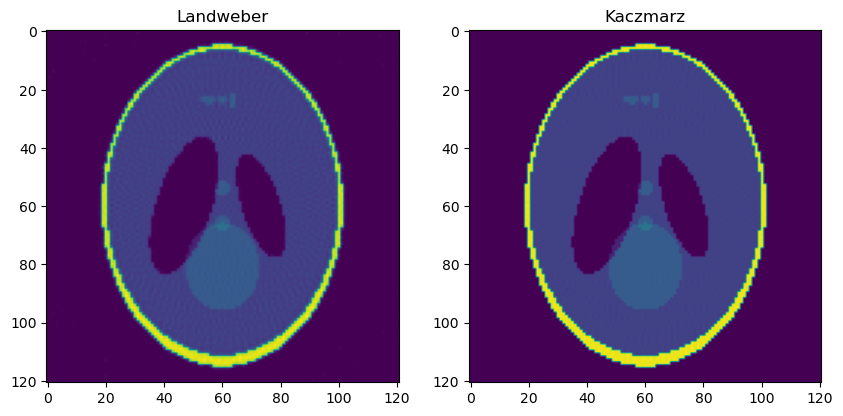

In [10]:
#Visualisation of the reconstructions
fig, (ax1, ax2) = plt.subplots(1, 2, num=3)
fig.set_size_inches(10,6)
ax1.imshow(fL)
ax1.set_title('Landweber')
ax2.imshow(fK)
ax2.set_title('Kaczmarz')
plt.show()

# With sparsity

In [11]:
#Computation of the projection matrix and data with sparse projection matrix
R1 = RT.RayTransform(parameters,modality=modality,datatype='sparse')
R1.computeProjectionMatrix(method='gaussian')
R2 = RT.RayTransform(parameters,modality=modality,datatype='sparse')
R2.computeProjectionMatrix(method='pixel')
g1 = R1.getData(f0)
g2 = R2.getData(f0)

Sparse Projection Matrix: [##########]100%  Time elapsed: 41.8 seconds
Sparse Projection Matrix: [##########]100%  Time elapsed: 6.1 seconds


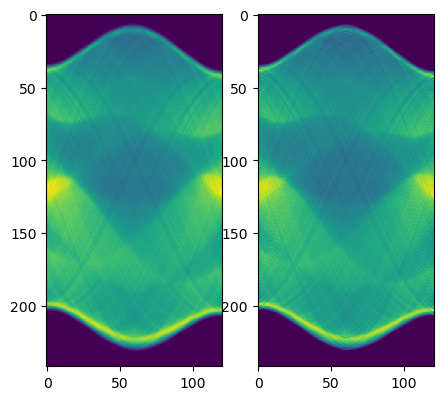

In [12]:
#Visualization of the data
fig, (ax1, ax2) = plt.subplots(1, 2, num=6)
fig.set_size_inches(5,5)
ax1.imshow(g1)
ax2.imshow(g2)
plt.show()

In [18]:
f1 = R1.FBP(g1,filtertype="hann")
f2 = R2.FBP(g2,filtertype="hann")

FBP: [##########]100%  Time elapsed: 0.1 seconds
FBP: [##########]100%  Time elapsed: 0.1 seconds


In [14]:
#fL1 = R1.Landweber(g1, relax=0.0001, tikhonov_param=0, iterations=500)

In [15]:
fK2 = R2.ART(g2,sweeps=3)

ART: [##########]100%  Time elapsed: 331.6 seconds


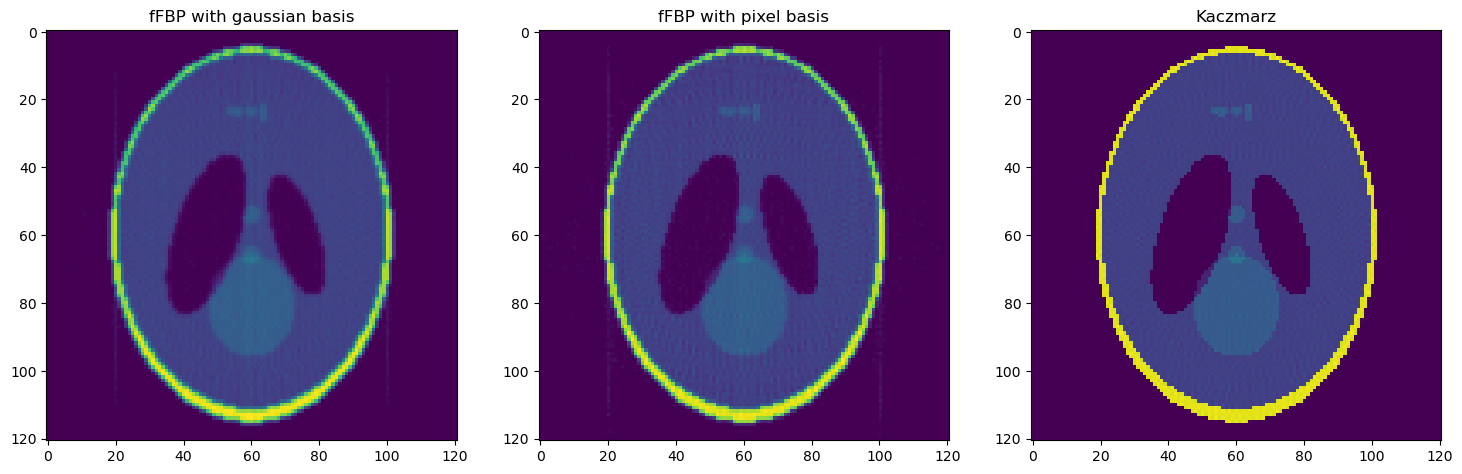

In [19]:
#Visualisation of the reconstructions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, num=3)
fig.set_size_inches(18,10)
ax1.imshow(f1)
ax1.set_title('fFBP with gaussian basis')
ax2.imshow(f2)
ax2.set_title('fFBP with pixel basis')
ax3.imshow(fK2)
ax3.set_title('Kaczmarz')
plt.show()